In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
%matplotlib inline

# Turn off scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Import data
tn_budget = pd.read_csv('Data/Zipped_Data/tn.movie_budgets.csv.gz', compression = 'gzip')
bom_gross = pd.read_csv('Data/Zipped_Data/bom.movie_gross.csv.gz', compression = 'gzip')
imbd_basics = pd.read_csv('Data/Zipped_Data/imdb.title.basics.csv.gz', compression = 'gzip')
imbd_name = pd.read_csv('Data/Zipped_Data/imdb.name.basics.csv.gz', compression = 'gzip')
imbd_principals = pd.read_csv('Data/Zipped_Data/imdb.title.principals.csv.gz', compression = 'gzip')

In [2]:
# Remove punctuation from producton and worldwide. Switch variables from string to float.
tn_budget['production_budget'] = tn_budget['production_budget'].apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget['worldwide_gross'] = tn_budget['worldwide_gross'].apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget['production_budget'] = pd.to_numeric(tn_budget.production_budget, downcast = 'float', errors = 'coerce')
tn_budget['worldwide_gross'] = pd.to_numeric(tn_budget.worldwide_gross, downcast = 'float', errors = 'coerce')

# Create column for net profit (worldwide gross minus production budget).
tn_budget['net'] = list(tn_budget.apply(lambda x: x.worldwide_gross - x.production_budget, axis=1))

# Create column for ratio (net profit divided by production budget)
tn_budget['ratio'] = list(tn_budget.apply(lambda x: x.net / x.production_budget, axis=1))

# Rename column 'movie' to 'title'
tn_budget = tn_budget.rename(columns = {'movie': 'title'})

# Remove whitespace, potential extra words, punctuation, and case from titles
years = ['\(2010\)', "\(2011\)", 
         "\(2012\)", "\(2013\)", "\(2014\)", 
         "\(2015\)", "\(2016\)", "\(2017\)", "\(2018\)"]
tn_budget.title = tn_budget.title.replace(years, value='', regex=True)
tn_budget.title = tn_budget.title.str.strip()
tn_budget.title = tn_budget.title.apply(lambda x: x.lower())
tn_budget.title = tn_budget.title.apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget.title = tn_budget.title.replace(['the', 'and'], value='', regex=True)

# Remove month and year from date. Drop redundant columns
tn_budget['year'] = list(tn_budget['release_date'].str[-4:])
tn_budget = tn_budget.drop(columns = ['id', 'domestic_gross', 'release_date'])

In [3]:
# Remove 'studio', 'domestic_gross', 'foreign_gross' column. Set 'foreign_gross' to float and 'year' to string
bom_gross = bom_gross.drop(columns = ['domestic_gross', 'foreign_gross'])
bom_gross['year'] = bom_gross['year'].astype(str)

# Remove years and right whitespace from titles. Remove potentially extraneous words.
years = ['\(2010\)', "\(2011\)", 
         "\(2012\)", "\(2013\)", "\(2014\)", 
         "\(2015\)", "\(2016\)", "\(2017\)", "\(2018\)"]
bom_gross.title = bom_gross.title.replace(years, value='', regex=True)
bom_gross.title = bom_gross.title.str.strip()
bom_gross.title = bom_gross.title.apply(lambda x: x.lower())
bom_gross.title = bom_gross.title.apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
bom_gross.title = bom_gross.title.replace(['the', 'and'], value='', regex=True)

In [4]:
# Merge tn_budget and bom_gross
merged_df = pd.merge(tn_budget, bom_gross, on = ["title", "year"], how = "left")

# Replace null studio values
merged_df['studio'] = merged_df.studio.fillna('Unknown')

In [5]:
# Create 'year' string column from 'start_year'
imbd_basics['year'] = imbd_basics['start_year'].astype(str)

# Drop unused columns
imbd_basics = imbd_basics.drop(columns = ['original_title', 'start_year'])

# Rename column for easier merging
imbd_basics = imbd_basics.rename(columns = {'primary_title': 'title'})

# Remove years and right whitespace from titles. Remove potentially extraneous words.
years = ['\(2010\)', "\(2011\)", 
         "\(2012\)", "\(2013\)", "\(2014\)", 
         "\(2015\)", "\(2016\)", "\(2017\)", "\(2018\)"]
imbd_basics.title = imbd_basics.title.replace(years, value='', regex=True)
imbd_basics.title = imbd_basics.title.str.strip()
imbd_basics.title = imbd_basics.title.apply(lambda x: x.lower())
imbd_basics.title = imbd_basics.title.apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
imbd_basics.title = imbd_basics.title.replace(['the', 'and'], value='', regex=True)

In [6]:
# Merge imbd_basics with merged datafile
merged_df2 = pd.merge(merged_df, imbd_basics, on = ["title", "year"], how = "left")

# Change year to integer, and remove all films made before 2010. Turn year back to string.
merged_df2['year'] = merged_df2['year'].astype(int)
merged_df2 = merged_df2.loc[merged_df2.year >= 2010]
merged_df2['year'] = merged_df2['year'].astype(str)

In [7]:
# Merge imbd_principals and imbd_name
imbd_name_prin = pd.merge(imbd_principals, imbd_name, on = ["nconst"], how = "left")

# Remove extraneous columns
imbd_name_prin = imbd_name_prin.drop(columns = ['ordering', 'nconst', 
                               'job', 'characters', 'birth_year', 'death_year', 
                               'primary_profession', 'known_for_titles'])

In [8]:
# Create list of directors from imbd_name_prin
directors = imbd_name_prin.loc[imbd_name_prin.category == 'director']

In [9]:
# Merge list of directors with merged document
merged_df3 = pd.merge(merged_df2, directors, on = ["tconst"], how = "left")

# Remove extra columns, rename primary_name to director
merged_df3 = merged_df3.drop(columns = ['category', 'runtime_minutes', 'genres'])
merged_df3 = merged_df3.rename(columns = {'primary_name': 'director'})

# Fill in null values for director
merged_df3['director'] = merged_df3.director.fillna('Not listed')

In [10]:
# Create list of producers from imbd_name_prin
producers = imbd_name_prin.loc[imbd_name_prin.category == 'producer']

# Rename column primary_name to producer
producers = producers.rename(columns = {'primary_name': 'producer'})

# Drop column 'category'
producers = producers.drop(columns = 'category')

In [11]:
# Merge list of producers with merged document
merged_df4 = pd.merge(merged_df3, producers, on = ["tconst"], how = "left")

# Fill null producer values
merged_df4['producer'] = merged_df4.producer.fillna('Not listed')

# Remove duplicate titles
merged_df_cleaned = merged_df4.loc[merged_df4.title.duplicated() == False]

# Drop extra column
merged_df_cleaned = merged_df_cleaned.drop(columns = 'tconst')

In [12]:
# Create a list of 20 studios with the top ratio means
studio_ratio_mean = merged_df_cleaned.groupby(['studio']).ratio.mean().sort_values(ascending=False)[:20]

# Create a list of 20 directors with the top ratio means
director_ratio_mean = merged_df_cleaned.groupby(['director']).ratio.mean().sort_values(ascending=False)[:20]

# Create a list of 20 producers with the top ratio means
producer_ratio_mean = merged_df_cleaned.groupby(['producer']).ratio.mean().sort_values(ascending=False)[:20]

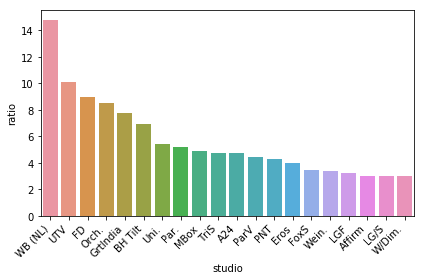

In [13]:
# Make a barplot - top 20 studios by ROI
top_20_studios_ROI = (merged_df_cleaned.groupby('studio')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='ratio', ascending=False))[:20].reset_index()
ax = sns.barplot(x = top_20_studios_ROI['studio'], y = top_20_studios_ROI['ratio'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

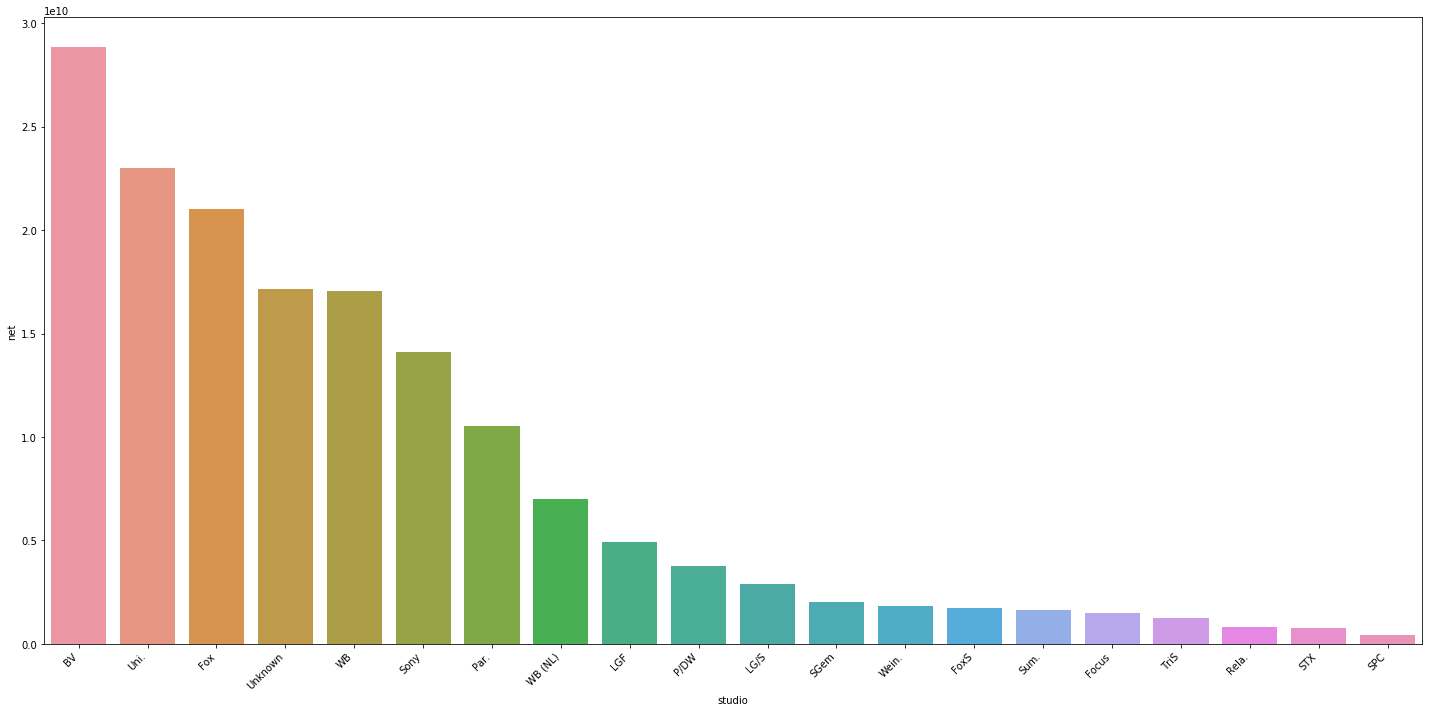

In [14]:
# Make a barplot - top 20 studios by net profit
top_20_studios_gross = (merged_df_cleaned.groupby('studio')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='net', ascending=False))[:20].reset_index()
ax = sns.barplot(x = top_20_studios_gross['studio'], y = top_20_studios_gross['net'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

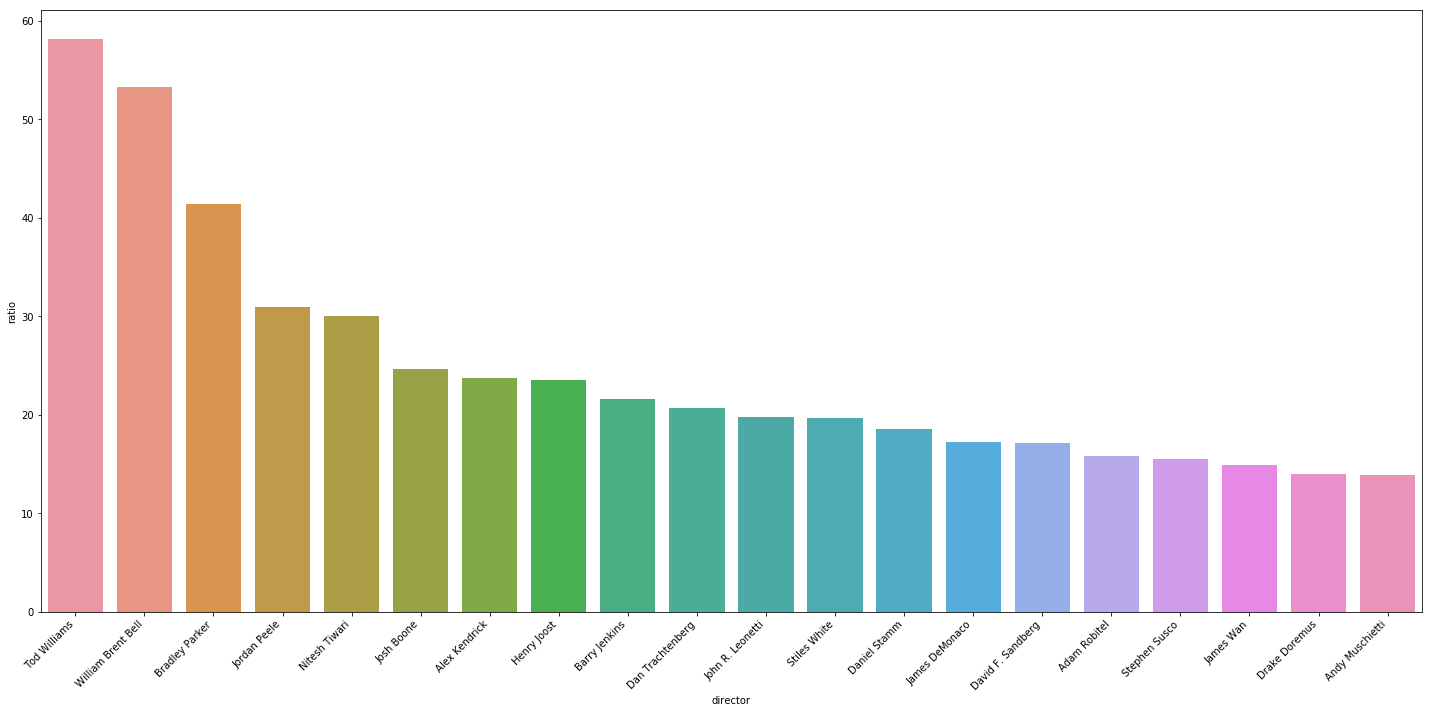

In [15]:
#Make a barplot - top 20 directors by ROI
top_20_directors_ROI = (merged_df_cleaned.groupby('director')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='ratio', ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_directors_ROI['director'], y = top_20_directors_ROI['ratio'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()
# N.B. - Dropped Travis Cluff due to assumed outlier status.

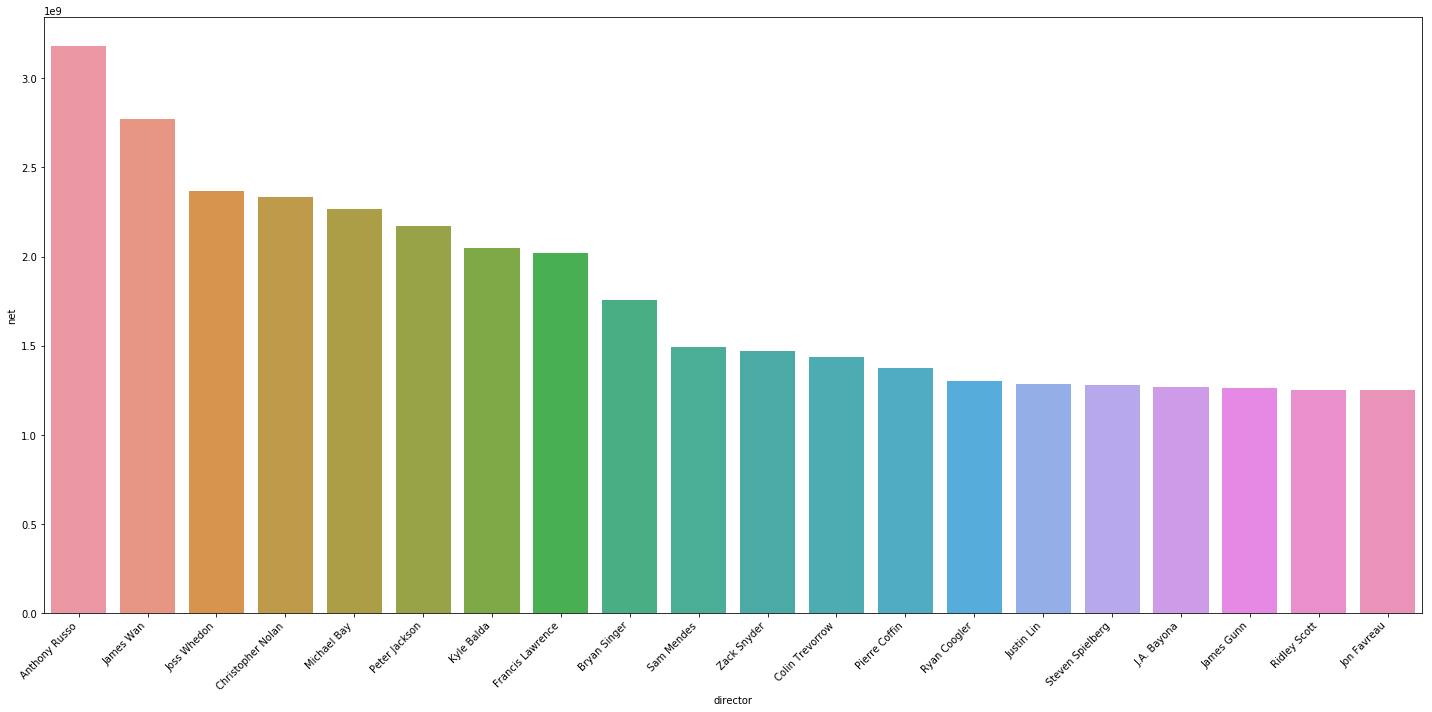

In [16]:
#Make a barplot - top 20 directors by net profit
top_20_directors_gross = (merged_df_cleaned.groupby('director')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='net', ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_directors_gross['director'], y = top_20_directors_gross['net'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

C:\Users\Rocio\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


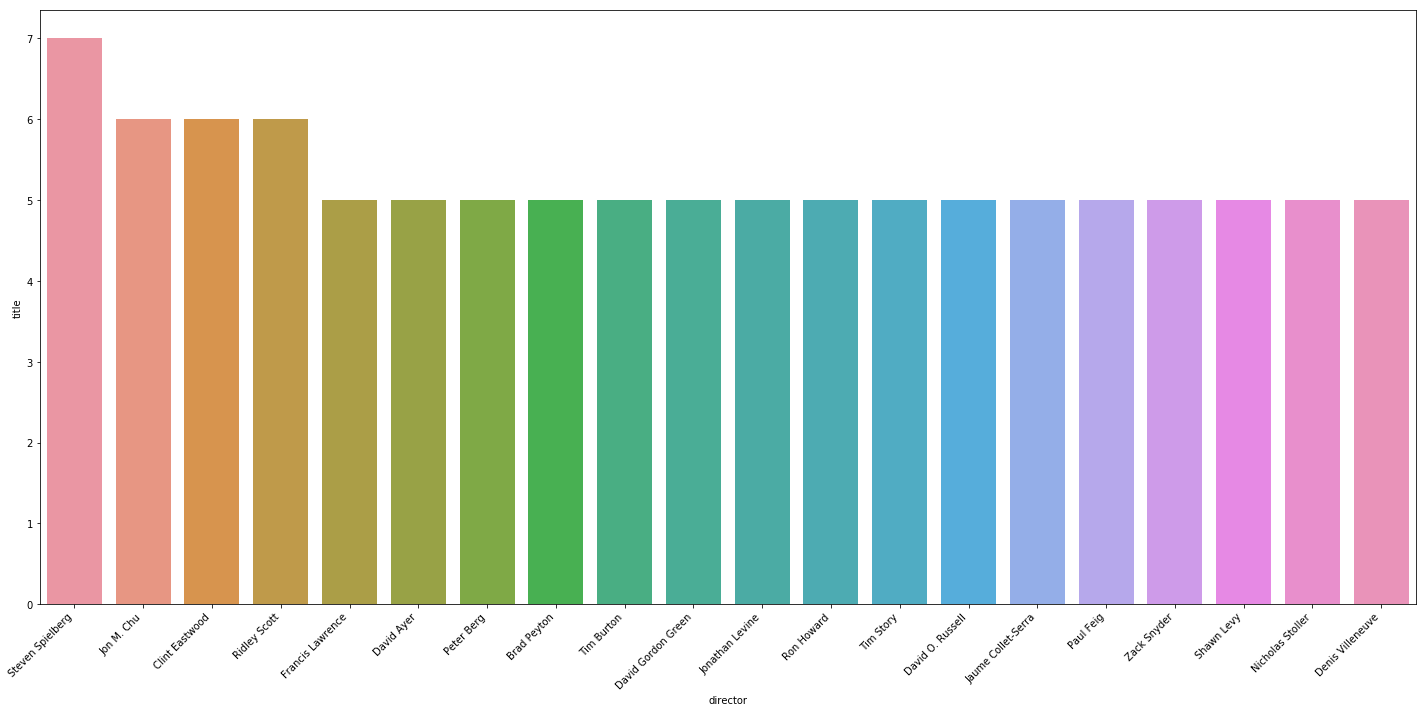

In [17]:
top_20_directors_count = (merged_df_cleaned.groupby('director')['title'].agg({'title': 'nunique'}).sort_values(by=['title'], ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_directors_count['director'], y = top_20_directors_count['title'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

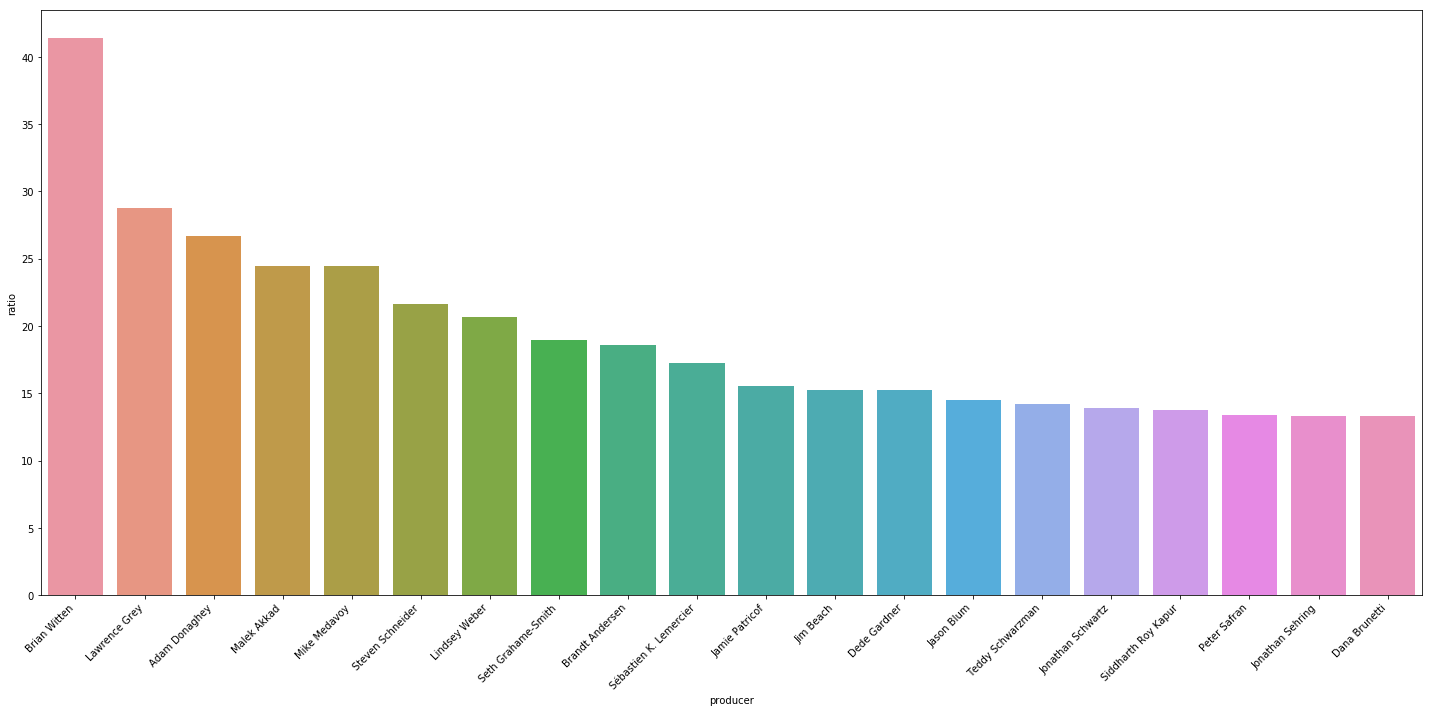

In [18]:
#Make a barplot - top 20 producers by ROI
top_20_producers_ROI = (merged_df_cleaned.groupby('producer')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='ratio', ascending=False))[2:22].reset_index()
ax = sns.barplot(x = top_20_producers_ROI['producer'], y = top_20_producers_ROI['ratio'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()
# N.B. - threw out produers, "Dean Schnider" and "Morris Paulson" due to outlier presumption...

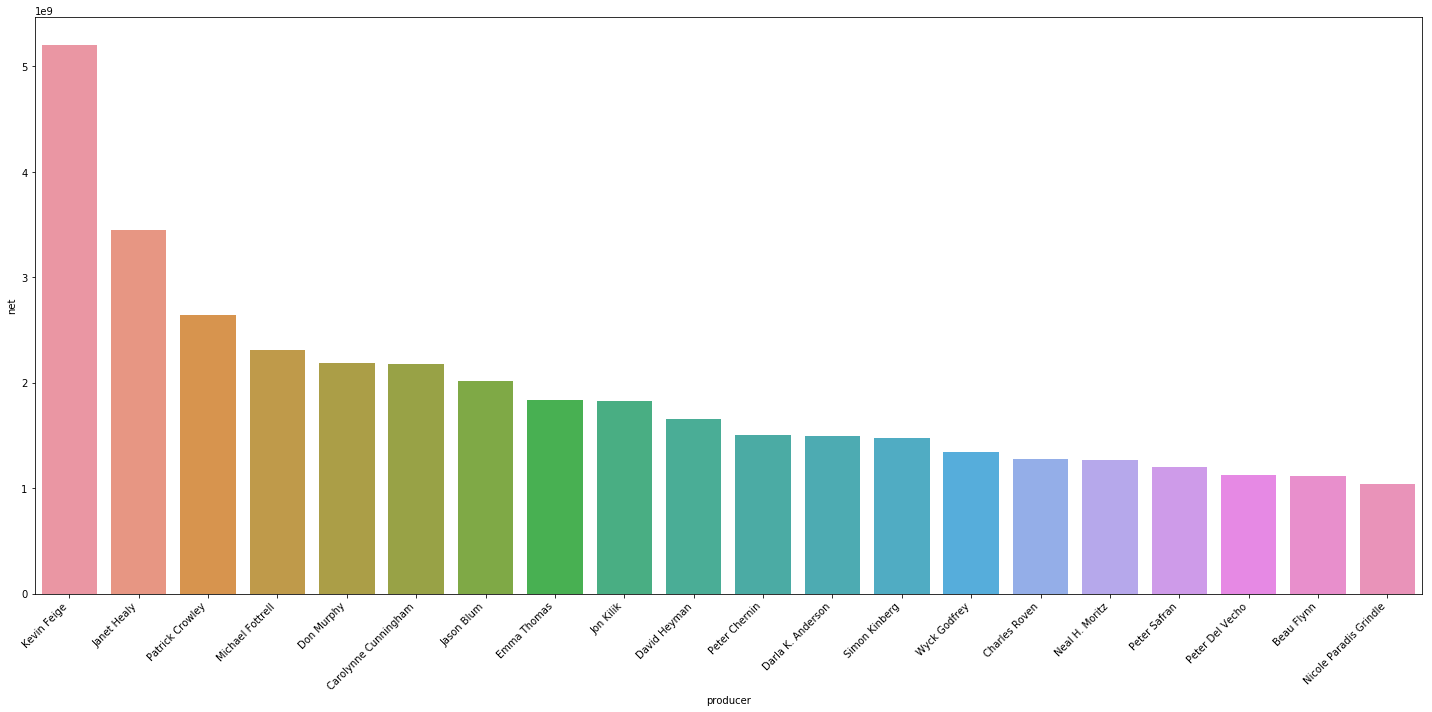

In [19]:
#Make a barplot - top 20 directors by net profit
top_20_producers_gross = (merged_df_cleaned.groupby('producer')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='net', ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_producers_gross['producer'], y = top_20_producers_gross['net'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

C:\Users\Rocio\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


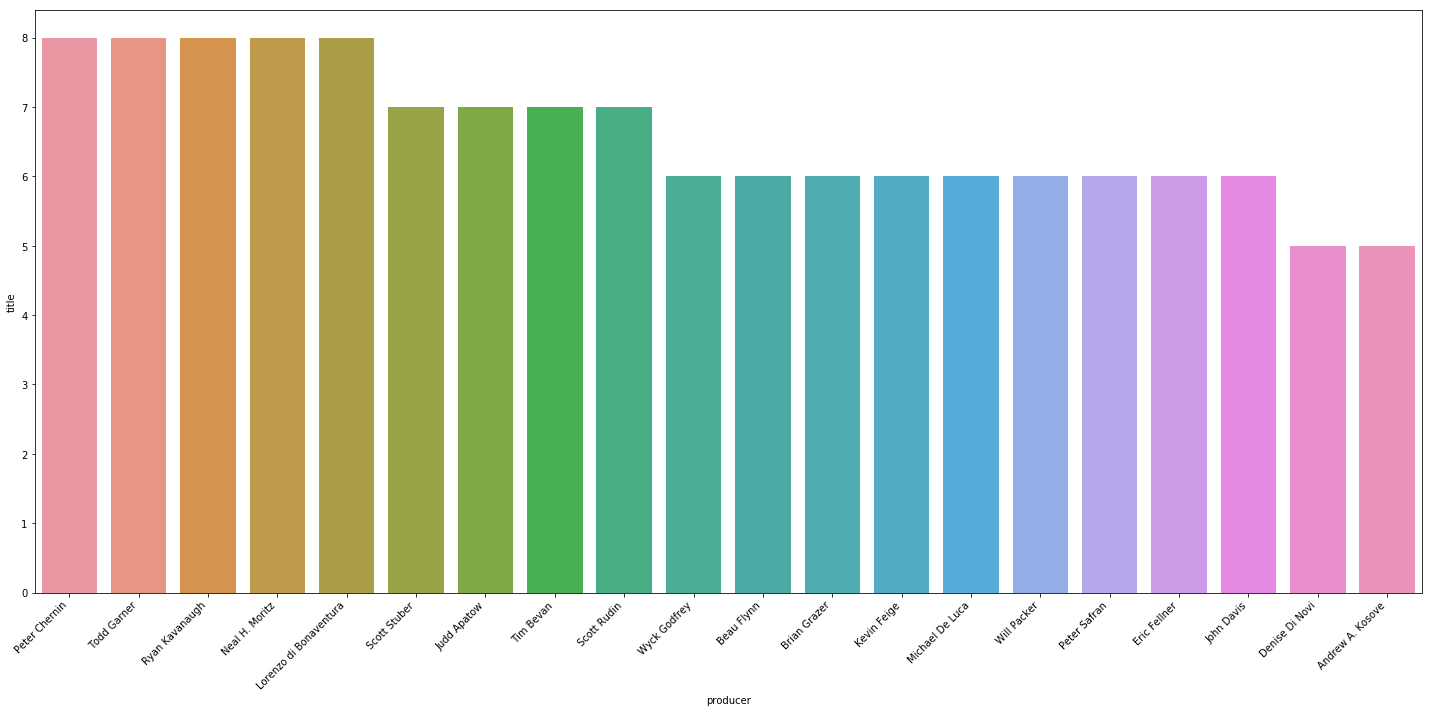

In [20]:
top_20_producers_count = (merged_df_cleaned.groupby('producer')['title'].agg({'title': 'nunique'}).sort_values(by=['title'], ascending=False))[2:22].reset_index()
ax = sns.barplot(x = top_20_producers_count['producer'], y = top_20_producers_count['title'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()
# N.B. - threw out producer Jason Blum; presumed outlier...

In [ ]:
#Make a barplot - top 20 directors by net profit - Count
top_20_producers_gross_count = (merged_df_cleaned.groupby('producer')['net', 'title'].agg({'net': 'sum', 'title': 'nunique'}).sort_values(by='net', ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_producers_gross_count['producer'], y = top_20_producers_gross_count['title'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

In [ ]:
#Make a barplot - top 20 producers by ROI - Count
top_20_producers_ROI_count = (merged_df_cleaned.groupby('producer')['ratio', 'title'].agg({'ratio': 'mean', 'title': 'nunique'}).sort_values(by='ratio', ascending=False))[2:22].reset_index()
ax = sns.barplot(x = top_20_producers_ROI_count['producer'], y = top_20_producers_ROI_count['title'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()
#N.B. - threw out produers, "Dean Schnider" and "Morris Paulson" due to outlier presumption...

In [ ]:
#Make a barplot - top 20 directors by net profit - count
top_20_directors_gross_count = (merged_df_cleaned.groupby('director')['net', 'title'].agg({'net': 'sum', 'title': 'nunique'}).sort_values(by='net', ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_directors_gross_count['director'], y = top_20_directors_gross_count['title'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()